## 🚲 Bike Sharing Analysis 🚲

In [1]:
# importing IPython relevant libraries
from IPython.display import Image
from IPython.core.display import HTML

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# insert image
Image(url= "https://upload.wikimedia.org/wikipedia/commons/d/dc/Capital_Bikeshare_DC_2010_10_544.JPG")

### 🗄️ 1. Data Collection: Reading and Visualizing Data + Understanding the Goal

#### 1.1. Introduction
Through this notebook, we will analyse bike sharing in Washington, D.C. We will start by exploring the dataset (ensuring data quality, visualizing the data and extracting insights on relevant features). Feature engineering will follow by handling null values, outliers, text and date features, the generation of extra features, and the use of pipelines to perform transformations. Finally, we will use predictive analytics (ML) to choose the right model, tune its parameters, obtain accurate predictions on test (measured with R2 score), and plot predictions vs. reality for additional insights).

##### Goal: build a model that predicts the total number of Washington D.C. bicycle users on an hourly basis.

#### 1.2 Feature descriptions:
The features present in this report are defined as follows:

### Data Exploration
**Name** | **Description**
-------------------:|--------------------
instant       |  Record index
dteday | Date
hr | Hour
weathersit | Weather situation
temp | Normalized temperature in Celsius. The values are divided to 41 (max)
atemp | Normalized feeling temperature in Celsius. The values are divided to 50 (max)
hum | Normalized humidity. The values are divided to 100 (max)
windspeed | Normalized wind speed. The values are divided to 67 (max)
casual | count of casual users
registered | count or registered users
cnt | count of total rental bikes including both casual and registered

In [2]:
#pip install holidays

In [3]:
# Imports of Pandas, NumPy and data visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
import holidays
import datetime
import seaborn as sns
from ipywidgets import interact
import matplotlib.dates as mdates

# Imports of necessary preprocessing libraries
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, Normalizer, normalize, MinMaxScaler, RobustScaler, StandardScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import r2_score, confusion_matrix
from sklearn import set_config

# Imports of essential ML libraries
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [4]:
# Importing dataset with specified index_col and parsing dates
df = pd.read_csv("hour.csv", index_col="instant", parse_dates=["dteday"])
df.head()

,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,
1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,0,1,1


### 🧐 2. Exploratory Data Analysis (Descriptive Analytics)

In this section, we will cover the following points:
* Ensuring data quality (correctness, consistency, missing values, outliers).
* Plotting clear and meaningful figures.
* Giving insights on what seems relevant for prediction and what does not.
* Checking possibly redundant variables via correlations.

#### 2.1. Ensuring data quality

In [5]:
#Renaming date columns for clarity
df = df.rename(columns={"dteday": "date"})

In [6]:
#Checking that the data is in the correct format
df.dtypes

date          datetime64[ns]
hr                     int64
weathersit            object
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

In [7]:
#Correcting datatype of `weathersit`
df["weathersit"] = df.weathersit.astype('category')
df.dtypes

date          datetime64[ns]
hr                     int64
weathersit          category
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

In [8]:
# Checking if the index is unique
df.index.is_unique

True

In [9]:
# Check if the is the index increasing monotonically or if we need to resample
df.index.is_monotonic_increasing

True

In [10]:
#A general description of the dataset
df.describe()

,hr,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.000000,17280.000000,17279.000000,17279.000000,17279.000000,17379.000000,17379.000000,17379.000000
mean,11.546752,0.497071,0.475530,0.627235,0.190114,35.676218,153.786869,189.463088
std,6.914405,0.192474,0.171782,0.193047,0.122378,49.305030,151.357286,181.387599
min,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,6.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,12.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,18.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,23.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [11]:
# Checking null values
df.isnull().any()

date          False
hr            False
weathersit     True
temp           True
atemp          True
hum            True
windspeed      True
casual        False
registered    False
cnt           False
dtype: bool

In [12]:
#Checking sum of null values
df.isnull().sum()

date            0
hr              0
weathersit    100
temp           99
atemp         100
hum           100
windspeed     100
casual          0
registered      0
cnt             0
dtype: int64

> `weathersit`, `temp`, `atemp`, `hum`, and `windspeed` have a high number of misisng values that need to be dealt with.

In [13]:
#Null values in `hum`
df.loc[df["hum"].isnull()]

,date,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,
251,2011-01-11,19,"Light Snow, Light Rain + Thunderstorm + Scatte...",0.16,0.2273,NaN,0.0000,0,51,51
287,2011-01-13,9,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.14,0.1212,NaN,0.3284,2,137,139
386,2011-01-17,13,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.18,0.1970,NaN,0.1343,13,80,93
500,2011-01-22,21,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.06,0.1061,NaN,0.0896,0,39,39
525,2011-01-23,23,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.06,0.0606,NaN,0.2239,4,17,21
...,...,...,...,...,...,...,...,...,...,...
16210,2012-11-13,3,"Light Snow, Light Rain + Thunderstorm + Scatte...",0.36,0.3333,NaN,0.3582,2,3,5
16365,2012-11-19,14,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.44,0.4394,NaN,0.2537,47,170,217
16623,2012-11-30,9,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2576,NaN,0.0896,17,313,330


> As we have hourly data, it would make sense to impute the null values using ffill (takes previous value).  In order to do that, we first checked that the missing values were not consecutive without altering the results.


#### Checking possibly redundant variables via correlations.

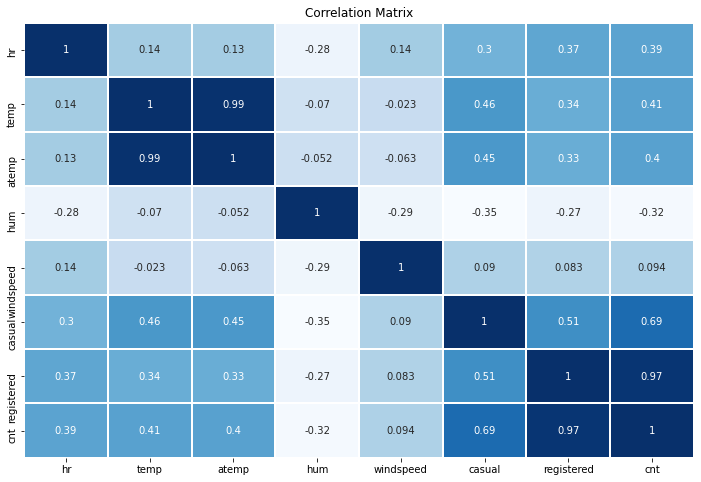

In [14]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cbar=False, linewidths=1, cmap="Blues")
plt.title("Correlation Matrix")
plt.show()

Main insights from correlation matrix:
* `casual` and `registered`'s sum is equal to the target variable `cnt`. We will drop both variables.
* `temp` is highly correlated with `atemp` (more than 99% correlation). So, we decide to drop `temp`

In [15]:
#Drop casual and registered
df = df.drop(["casual", "registered"], axis = 1)

In [16]:
df.head()

,date,hr,weathersit,temp,atemp,hum,windspeed,cnt
instant,,,,,,,,
1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,16
2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,40
3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,32
4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,13
5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,1


We decided to show the description of the dataframe to check for inconsistencies. We realized that `windspeed` is not properly normalized as the max should be 1. 

We also saw inconsistencies in `temp` but, due to its high correlation with `atemp`, it will be dropped later on.

In [17]:
df.describe()

,hr,temp,atemp,hum,windspeed,cnt
count,17379.000000,17280.000000,17279.000000,17279.000000,17279.000000,17379.000000
mean,11.546752,0.497071,0.475530,0.627235,0.190114,189.463088
std,6.914405,0.192474,0.171782,0.193047,0.122378,181.387599
min,0.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,6.000000,0.340000,0.333300,0.480000,0.104500,40.000000
50%,12.000000,0.500000,0.484800,0.630000,0.194000,142.000000
75%,18.000000,0.660000,0.621200,0.780000,0.253700,281.000000
max,23.000000,1.000000,1.000000,1.000000,0.850700,977.000000


We correct the normalization of `windspeed` with a correcting factor, calculated by the given value in the description (from 0-0.85 to 0-1).

In [18]:
df["windspeed"]=df["windspeed"]/(.8507)

#### Plotting clear and meaningful figures.

**a. Checking the distribution of the variables**

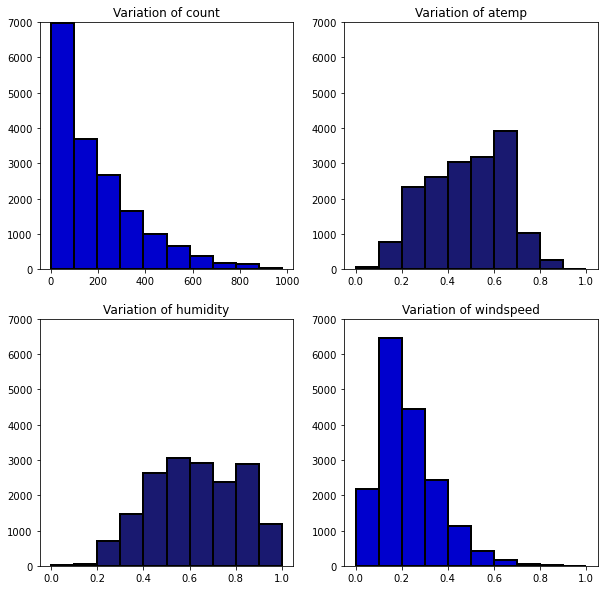

In [19]:
#Distribution of Variables
fig,axes=plt.subplots(2,2)
axes[0,0].hist(x="cnt",data=df,edgecolor="black",linewidth=2, color = "mediumblue")
axes[0,0].set_title("Variation of count")
axes[0,0].set_ylim([0, 7000]) 
axes[0,1].hist(x="atemp",data=df,edgecolor="black",linewidth=2, color = "midnightblue")
axes[0,1].set_title("Variation of atemp")
axes[0,1].set_ylim([0, 7000])
axes[1,0].hist(x="hum",data=df,edgecolor="black",linewidth=2, color = "midnightblue")
axes[1,0].set_title("Variation of humidity")
axes[1,0].set_ylim([0, 7000])
axes[1,1].hist(x="windspeed",data=df,edgecolor="black",linewidth=2, color = "mediumblue")
axes[1,1].set_title("Variation of windspeed")
axes[1,1].set_ylim([0, 7000])
fig.set_size_inches(10,10)

As we dropped `casual` and `registered`, all of the remaining variables are normalized and we could argue there is no need to drop outliers, hence we dont want to drop them because it would affect our index which is increasing at a constant rate.

**b. Count of Bike Rentals by Temperature**

The `temp` is scaled between 0 and 1, but the given `temp` is between 0 and 50 degrees. We simply multiply by 50 to denormalize `temp` and visualize the real temperature.

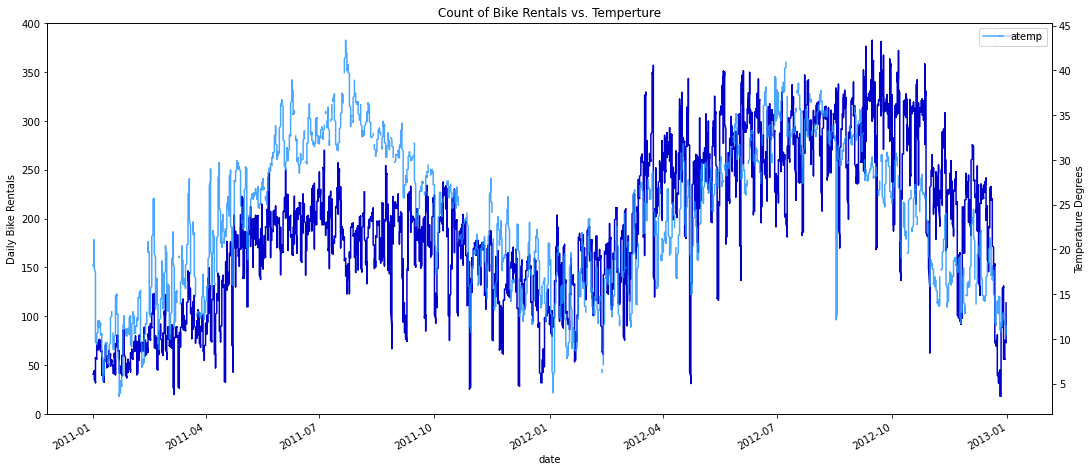

In [20]:
df2 = df.set_index('date')

fig, ax1 = plt.subplots() # I need to change the X axis to daily 

df2["cnt"].rolling(24).mean().plot(title= 'Count of Bike Rentals vs. Temperture', color = 'mediumblue', figsize=(18,8),legend=True, ylabel='Daily Bike Rentals')

ax2 = ax1.twinx()
(df2['atemp']*50).rolling(24).mean().plot(alpha=0.8, color = 'dodgerblue', figsize=(18,8),legend=True, ylabel='Temperature Degrees')
plt.show()

> We can see that temperature influences bike rental (as temp increases, bike rentals increase). 

**c. Count of Bike Rentals by Humidity**

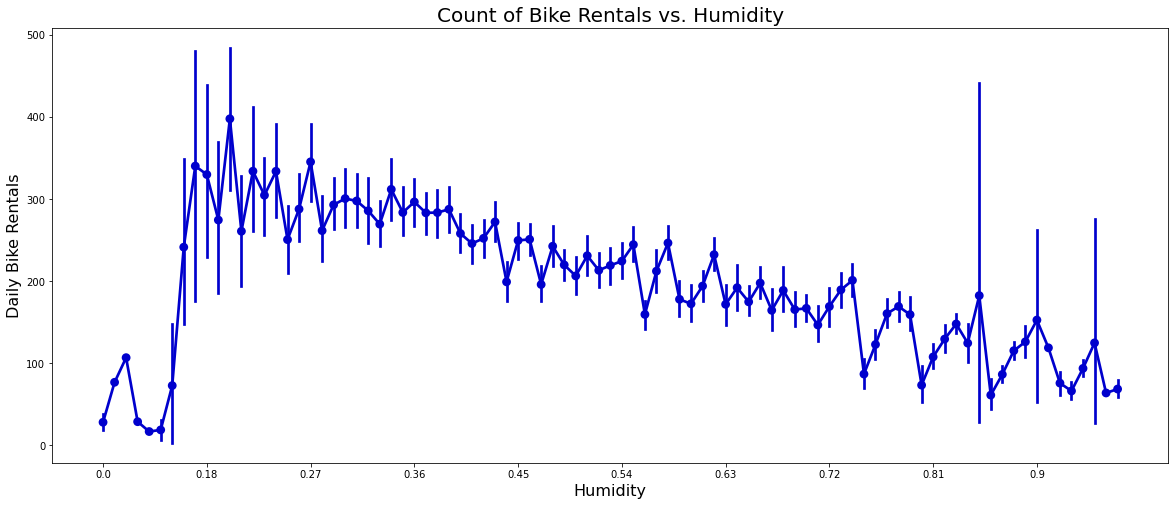

In [21]:
plt.figure(figsize=(20,8))

ax = sns.pointplot(x='hum', y='cnt', data=df, color = "mediumblue")
ax.set_title("Count of Bike Rentals vs. Humidity", fontsize=20)
ax.set_xlabel("Humidity", fontsize=16)
ax.set_ylabel('Daily Bike Rentals', fontsize=16)
plt.locator_params(axis='x', nbins=10)
plt.show()

> We can see that humidity influences bike rental (as humidity increases, bike rentals decrease). 

**d. Count of Bike Rentals by Temperature**

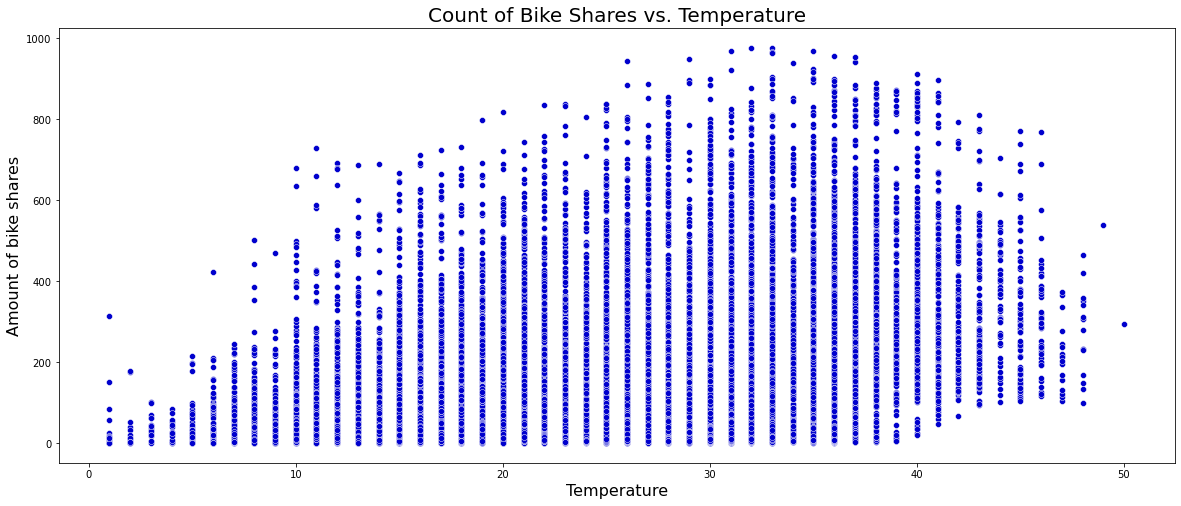

In [22]:
plt.figure(figsize=(20,8))
df2["temp2"]= df2["temp"]*50
ax = sns.scatterplot(x="temp2", y='cnt', data=df2, color = "mediumblue")
ax.set_title("Count of Bike Shares vs. Temperature", fontsize=20)
ax.set_xlabel("Temperature", fontsize=16)
ax.set_ylabel('Amount of bike shares', fontsize=16)
plt.locator_params(axis='x', nbins=10)
plt.show()

> The days with the highest bike rentals are between 20 and 35 (not too hot, not too cold).

**e. Count of Bike Rentals by Hour**

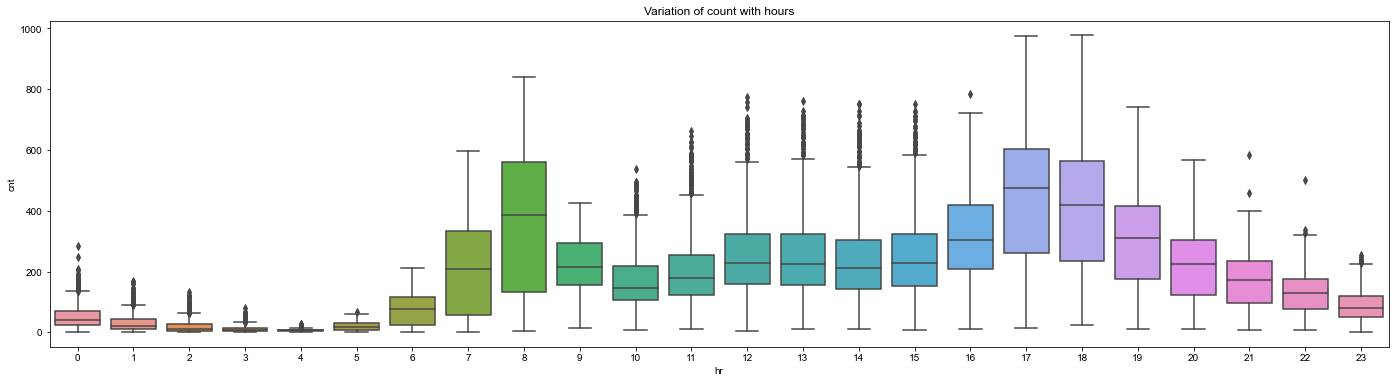

In [23]:
plt.figure(figsize=(24,6))
ax = sns.boxplot(data=df, x="hr", y="cnt")
ax.set_title('Variation of count with hours')
sns.set(style="whitegrid")
plt.show()

> Bike rentals show peak times at 8AM and 5PM. The highest count of bike rentals occur at 8AM, 5PM, and 6PM.

**f. Count of Bike Rentals by Windspeed**

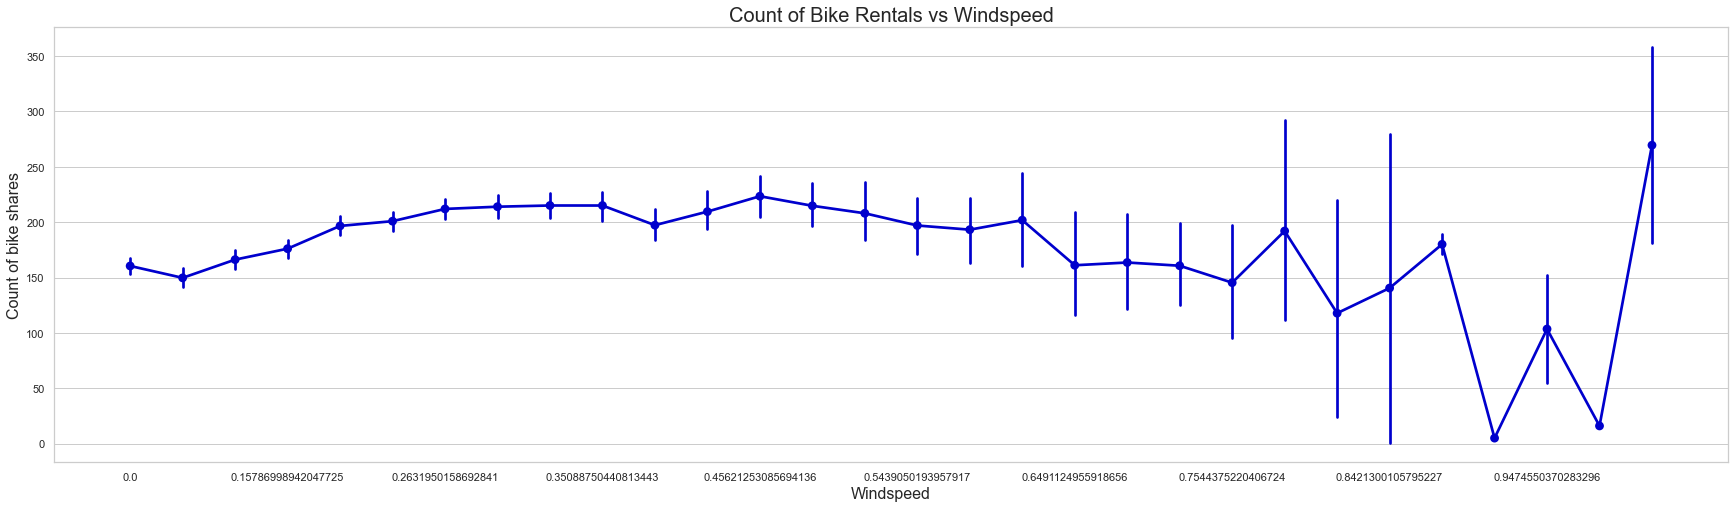

In [24]:
plt.figure(figsize=(30,8))

ax = sns.pointplot(x='windspeed', y='cnt', data=df, color = "mediumblue")
ax.set_title("Count of Bike Rentals vs Windspeed", fontsize=20)
ax.set_xlabel("Windspeed", fontsize=16)
ax.set_ylabel('Count of bike shares', fontsize=16)
plt.locator_params(axis='x', nbins=10)
plt.show()

> The higher the windspeed, the bigger the variation in bike rentals.

### 🤖 3. Data Engineering

In this section, we will cover the following points:
* Discussion on missing values and outliers.
* Treatment of text and date features.
* Generation of extra features.
* Use of scikit-learn pipelines to perform transformations

#### Generation of extra features:
We created `season`, `year`, `day_of_week`, `month`.

In [25]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day_of_week'] = pd.DatetimeIndex(df['date']).weekday  # Monday = 0, Sunday = 6
df['season'] = df.month%12 // 3 + 1  # We looked up how to code the season in pandas
df.head(5)

,date,hr,weathersit,temp,atemp,hum,windspeed,cnt,year,month,day_of_week,season
instant,,,,,,,,,,,,
1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,16,2011,1,5,1
2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,40,2011,1,5,1
3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,32,2011,1,5,1
4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,13,2011,1,5,1
5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,1,2011,1,5,1


In [26]:
#Making sure we have 4 seasons
df['season'].unique()

array([1, 2, 3, 4])

We created a boolean feature `is_weekday`: [0] = weekend; [1]= weekday 

In [27]:
df['is_weekday'] = np.where(df['day_of_week'].isin([5, 6]), 1, 0)
df.head()

,date,hr,weathersit,temp,atemp,hum,windspeed,cnt,year,month,day_of_week,season,is_weekday
instant,,,,,,,,,,,,,
1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,16,2011,1,5,1,1
2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,40,2011,1,5,1,1
3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,32,2011,1,5,1,1
4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,13,2011,1,5,1,1
5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,1,2011,1,5,1,1


We created a boolean feature `is_weekend`: [0] = weekday; [1]= weekend

In [28]:
df['is_weekend'] = np.where(df['day_of_week'].isin([5, 6]), 0, 1)
df.head()

,date,hr,weathersit,temp,atemp,hum,windspeed,cnt,year,month,day_of_week,season,is_weekday,is_weekend
instant,,,,,,,,,,,,,,
1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,16,2011,1,5,1,1,0
2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,40,2011,1,5,1,1,0
3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,32,2011,1,5,1,1,0
4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,13,2011,1,5,1,1,0
5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,1,2011,1,5,1,1,0


We created a boolean feature `is_daylight` that represents hours between 8AM to 6PM.

In [29]:
df['is_daylight'] = np.where(df['hr'].isin([8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]), 1, 0)
df.head()

,date,hr,weathersit,temp,atemp,hum,windspeed,cnt,year,month,day_of_week,season,is_weekday,is_weekend,is_daylight
instant,,,,,,,,,,,,,,,
1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,16,2011,1,5,1,1,0,0
2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,40,2011,1,5,1,1,0,0
3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,32,2011,1,5,1,1,0,0
4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,13,2011,1,5,1,1,0,0
5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,1,2011,1,5,1,1,0,0


In [30]:
df['weathersit'].unique()

['Clear, Few clouds, Partly cloudy, Partly cloudy', 'Mist + Cloudy, Mist + Broken clouds, Mist + F..., 'Light Snow, Light Rain + Thunderstorm + Scatt..., NaN, 'Heavy Rain + Ice Pallets + Thunderstorm + Mis...]
Categories (4, object): ['Clear, Few clouds, Partly cloudy, Partly cloudy', 'Mist + Cloudy, Mist + Broken clouds, Mist + F..., 'Light Snow, Light Rain + Thunderstorm + Scatt..., 'Heavy Rain + Ice Pallets + Thunderstorm + Mis...]

To create a `holiday` column, we first imported the python library of U.S. holidays.

In [31]:
holiday_list = []
for date in holidays.UnitedStates(years=[2011, 2012]).items():
    holiday_list.append(str(date[0]))
holiday_list

['2011-01-01',
 '2011-01-17',
 '2011-02-21',
 '2011-05-30',
 '2011-07-04',
 '2011-09-05',
 '2011-10-10',
 '2011-11-11',
 '2011-11-24',
 '2011-12-25',
 '2011-12-26',
 '2012-01-01',
 '2012-01-02',
 '2012-01-16',
 '2012-02-20',
 '2012-05-28',
 '2012-07-04',
 '2012-09-03',
 '2012-10-08',
 '2012-11-11',
 '2012-11-12',
 '2012-11-22',
 '2012-12-25']

Using the above information, we created a boolean feature `holiday`.

In [32]:
df['holiday'] = np.where(df['date'].isin(holiday_list), 1, 0)
df.head()

,date,hr,weathersit,temp,atemp,hum,windspeed,cnt,year,month,day_of_week,season,is_weekday,is_weekend,is_daylight,holiday
instant,,,,,,,,,,,,,,,,
1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,16,2011,1,5,1,1,0,0,1
2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,40,2011,1,5,1,1,0,0,1
3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,32,2011,1,5,1,1,0,0,1
4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,13,2011,1,5,1,1,0,0,1
5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,1,2011,1,5,1,1,0,0,1


#### Creating more visualizations for the newly created features to extract further insights

**a. Count of Bike Rentals by Holiday**

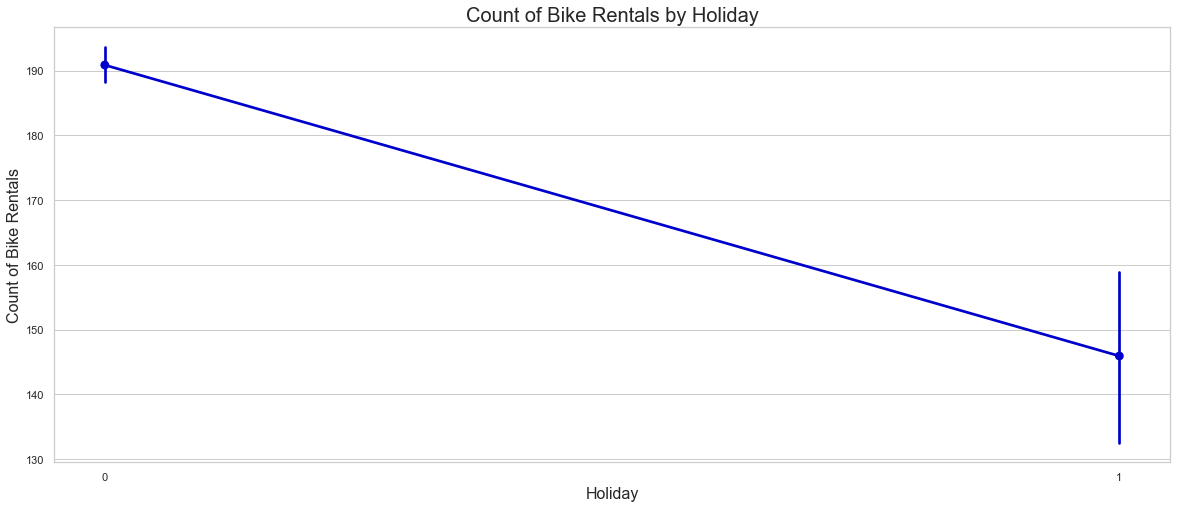

In [33]:
plt.figure(figsize=(20,8))

ax = sns.pointplot(x='holiday', y='cnt', data=df, color = "mediumblue")
ax.set_title("Count of Bike Rentals by Holiday", fontsize=20)
ax.set_xlabel("Holiday", fontsize=16)
ax.set_ylabel('Count of Bike Rentals', fontsize=16)
plt.locator_params(axis='x', nbins=10)
plt.show()

> On holidays, the count of bike rentals decreases a lot. We can assume that it is not a tourstic bike rental company since most of the bikes are used by working people on non-holiday days.

**b. Count of Bike Rentals by Day of Week**

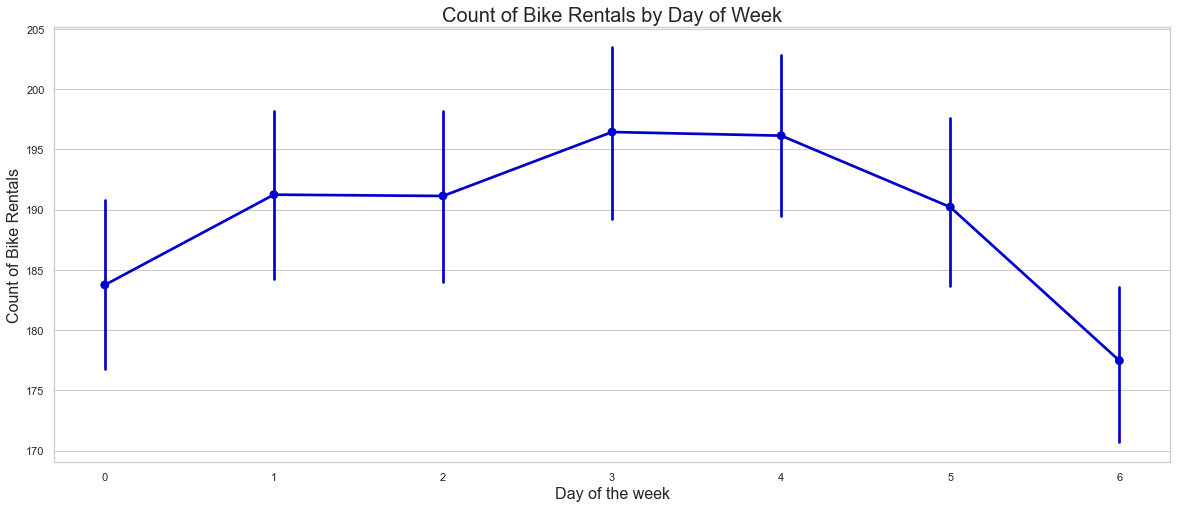

In [34]:
plt.figure(figsize=(20,8))

ax = sns.pointplot(x='day_of_week', y='cnt', data=df, color = "mediumblue")
ax.set_title("Count of Bike Rentals by Day of Week", fontsize=20)
ax.set_xlabel("Day of the week", fontsize=16)
ax.set_ylabel('Count of Bike Rentals', fontsize=16)
plt.locator_params(axis='x', nbins=10)
plt.show()

> As we have said before, bike rentals during the week are much higher than during the weekend. This once again confirms that it is not a touristic bike company.

**c. Count of Bike Rentals by Month of Year**

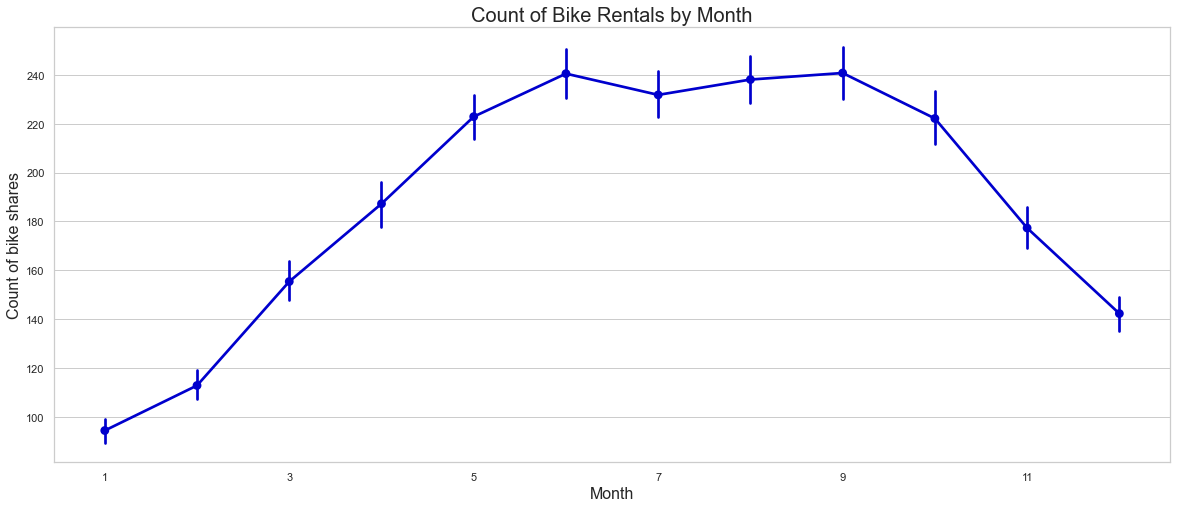

In [35]:
plt.figure(figsize=(20,8))

ax = sns.pointplot(x='month', y='cnt', data=df, color = 'mediumblue')
ax.set_title("Count of Bike Rentals by Month", fontsize=20)
ax.set_xlabel("Month", fontsize=16)
ax.set_ylabel('Count of bike shares', fontsize=16)
plt.locator_params(axis='x', nbins=10)
plt.show()

> During the sunny months (when the weather is better), bike rentals increase.

As stated previously, we observe peak hours for bike rentals. So, we create a boolean feature `peak_work_hour` for the peak times: 8AM, 17PM, 18PM. 

In [36]:
# create the new column as is_rushhour according to peak commute hours
df['peak_work_hour'] = np.where(df['hr'].isin([8, 17, 18])| (df['holiday'].isin([0])), 1, 0)
df.head()

,date,hr,weathersit,temp,atemp,hum,windspeed,cnt,year,month,day_of_week,season,is_weekday,is_weekend,is_daylight,holiday,peak_work_hour
instant,,,,,,,,,,,,,,,,,
1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,16,2011,1,5,1,1,0,0,1,0
2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,40,2011,1,5,1,1,0,0,1,0
3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,32,2011,1,5,1,1,0,0,1,0
4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,13,2011,1,5,1,1,0,0,1,0
5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,1,2011,1,5,1,1,0,0,1,0


**d. Count of Bike Rentals by Daylight**

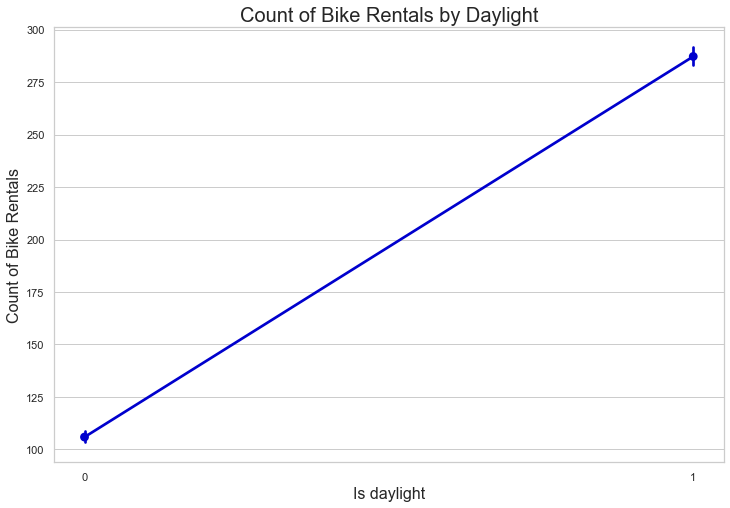

In [37]:
plt.figure(figsize=(12,8))

ax = sns.pointplot(x='is_daylight', y='cnt', data=df, color = "mediumblue")
ax.set_title("Count of Bike Rentals by Daylight", fontsize=20)
ax.set_xlabel("Is daylight", fontsize=16)
ax.set_ylabel('Count of Bike Rentals', fontsize=16)
plt.locator_params(axis='x', nbins=10)
plt.show()

> Obviously, bike rentals are way way higher during daylight.

**e. Count of Bike Rentals by Season**

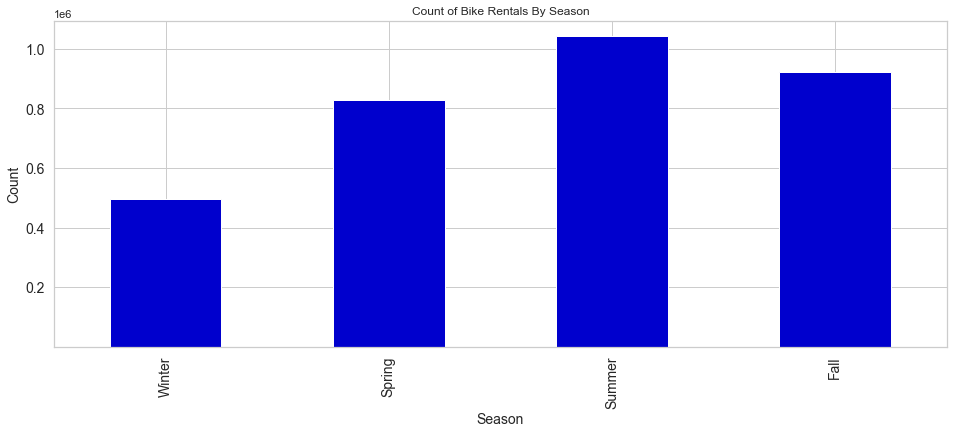

In [38]:
f,  ax1  =  plt.subplots(figsize=(16, 6)) #Defining output layout

ax1 = df[['season','cnt']].groupby(['season']).sum().reset_index().plot(kind='bar', 
                                       legend = False, title ="Count of Bike Rentals By Season", 
                                         stacked=True, fontsize=14, ax=ax1, color = "mediumblue")
ax1.set_xlabel("Season", fontsize=14)
ax1.set_ylabel("Count", fontsize=14)
ax1.set_xticklabels(['Winter','Spring','Summer','Fall'])
plt.show()

> The best seasons for bike rental are the ones with good weather (as seen before): Spring and Summer!

### 🔥 4. Predictive Analytics (Machine Learning)

In [39]:
# Defining target & feature columns:
X = df.drop(columns=['cnt'])
y = df[['cnt']]

We have to split the data into:
* Training data: whole 2011 and first 3 quarters of 2012
* Testing data: 4th quarter of 2012 

In [40]:
X_train = X.loc[X['date']  < '2012-09-01']
X_test = X.loc[X['date']  >= '2012-09-01']
y_train = y.loc[X['date']  < '2012-09-01'] 
y_test = y.loc[X['date']  >= '2012-09-01']

In [41]:
X_train = X_train.drop(columns="date")
X_test = X_test.drop(columns="date")

In [42]:
X_train

,hr,weathersit,temp,atemp,hum,windspeed,year,month,day_of_week,season,is_weekday,is_weekend,is_daylight,holiday,peak_work_hour
instant,,,,,,,,,,,,,,,
1,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.000000,2011,1,5,1,1,0,0,1,0
2,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.000000,2011,1,5,1,1,0,0,1,0
3,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.000000,2011,1,5,1,1,0,0,1,0
4,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.000000,2011,1,5,1,1,0,0,1,0
5,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.000000,2011,1,5,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14487,19,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.80,0.7424,0.49,0.157870,2012,8,4,3,0,1,0,0,1
14488,20,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.80,0.7424,0.49,0.157870,2012,8,4,3,0,1,0,0,1
14489,21,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.76,0.7121,0.58,0.228047,2012,8,4,3,0,1,0,0,1


We decided to fill the values of `weathersit` with the ffill method because it's a string and the values are consecutive. It makes sense that the weather of one hour will be the same as the weather of next hour. We will include this function inside of the pipeline.

In [43]:
def ffill_weather(series):
    return series.interpolate(method = 'ffill', limit_direction = "forward")

In [44]:
weather_fill_values = FunctionTransformer(ffill_weather)

**Preprocessing pipeline includes:**
* Transform all columns that have null values:
    * KNN Imputer -> `atemp` and `hum`
    * Fillna ffill function -> `weathersit`
    
* Creating dummy variables
    * OneHotEncoder() -> `weathersit`

* Passthrough for all the remaining variables.

In [45]:
preprocessing = ColumnTransformer([
    
    # temp dropper 
    ("temp_dropper", "drop", ["temp"]),
    
    # KNN Imputer to the Atemp variable
    ("atemp_fill_values", Pipeline([
        ("atemp_imputer", KNNImputer(n_neighbors=2)),
    ]), ["atemp"]),
    
     
    ("hum_fill_values", Pipeline([
        ("hum_imputer", KNNImputer(n_neighbors=2)), # knn imputer  
    ]), ["hum"]),
    
   
    ("wind_fill_values", SimpleImputer(strategy="median"), ["windspeed"]), # median imputer
    
    ("weathersit_fill_values", Pipeline([
       ("weathersit_fill", weather_fill_values),
        ("weathersit_encode", OneHotEncoder()), #one hot encode the weathersit column
    ]), ["weathersit"])
    
    
],remainder='passthrough')


In [46]:
set_config(display="diagram")
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('temp_dropper', 'drop', ['temp']),
                                ('atemp_fill_values',
                                 Pipeline(steps=[('atemp_imputer',
                                                  KNNImputer(n_neighbors=2))]),
                                 ['atemp']),
                                ('hum_fill_values',
                                 Pipeline(steps=[('hum_imputer',
                                                  KNNImputer(n_neighbors=2))]),
                                 ['hum']),
                                ('wind_fill_values',
                                 SimpleImputer(strategy='median'),
                                 ['windspeed']),
                                ('weathersit_fill_values',
                                 Pipeline(steps=[('weathersit_fill',
                                                  FunctionTransformer(func=<function ffill_weather at 0x7fc9cdd56af0>)),
                                                 ('weathersit_encode',
                                                  OneHotEncoder())]),
                                 ['weathersit'])])

Let's check if the preprocessing works!

In [47]:
X_preprocessed = preprocessing.fit_transform(X_train)
X_preprocessed.shape

(14491, 17)

In [48]:
X_preprocessed_df = pd.DataFrame(data=X_preprocessed, columns=['atemp','hum', 'windspeed','weathersit_1','weathersit_2','weathersit_3','weathersit_4','hr', 'year',
       'month', 'day_of_week', 'season', 'is_weekday', 'is_weekend','is_daylight', 'holiday', 'peak_work_hour' ])
X_preprocessed_df.describe()

,atemp,hum,windspeed,weathersit_1,weathersit_2,weathersit_3,weathersit_4,hr,year,month,day_of_week,season,is_weekday,is_weekend,is_daylight,holiday,peak_work_hour
count,14491.000000,14491.000000,14491.000000,14491.000000,14491.000000,14491.000000,14491.000000,14491.000000,14491.000000,14491.000000,14491.000000,14491.000000,14491.000000,14491.000000,14491.000000,14491.000000,14491.000000
mean,0.483932,0.623943,0.225877,0.665793,0.000207,0.084328,0.249672,11.549652,2011.403423,5.745497,3.003519,2.362294,0.286385,0.713615,0.461321,0.027879,0.975640
std,0.176109,0.196602,0.143807,0.471729,0.014387,0.277889,0.432838,6.912612,0.490601,3.186360,2.000187,1.008178,0.452087,0.452087,0.498519,0.164633,0.154169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2011.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333300,0.470000,0.122840,0.000000,0.000000,0.000000,0.000000,6.000000,2011.000000,3.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.500000,0.620000,0.228047,1.000000,0.000000,0.000000,0.000000,12.000000,2011.000000,6.000000,3.000000,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,0.621200,0.780000,0.298225,1.000000,0.000000,0.000000,0.000000,18.000000,2012.000000,8.000000,5.000000,3.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,23.000000,2012.000000,12.000000,6.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Ridge Regression: 
After all the preprocessing steps, we can use some regularization methods to analyze which features are more important. Ridge is an embedded method focused on applying a regularization penalty to the model complexity. Utilizing this regularization, you can force the model to reduce the attention that it is paying to less relevant features.

The results of the Ridge (L2) regression display the importance of each feature.

In [49]:
ridge_mod = LogisticRegression(max_iter=1000,penalty='l2')
print("Accuracy = {:.4}".format(np.mean(cross_val_score(ridge_mod, X_preprocessed, y_train, cv=5))))

Accuracy = 0.01622


In [50]:
def get_feature_importance(clf, feature_names):
    """
    Function to print the most important features of a logreg classifier based on the coefficient values
    """
    return pd.DataFrame({'variable': feature_names, # Feature names
                         'coefficient': clf.coef_[0] # Feature Coeficients
                    }) \
    .round(decimals=2) \
    .sort_values('coefficient', ascending=False) \
    .style.bar(color=['red', 'green'], align='zero')

In [51]:
get_feature_importance(ridge_mod.fit(X_preprocessed_df,y_train), X_preprocessed_df.columns.get_level_values(0).tolist())

,variable,coefficient
5,weathersit_3,0.070000
13,is_weekend,0.030000
2,windspeed,0.020000
1,hum,0.010000
8,year,0.000000
15,holiday,0.000000
16,peak_work_hour,-0.000000
4,weathersit_2,-0.000000
6,weathersit_4,-0.030000
12,is_weekday,-0.030000


> As observed in the feature important from Ridge Regression, the most important features are: `weathersit`, `hour`, `season`, `is_daylight`. 

In [52]:
X_preprocessed_df.isnull().sum()

atemp             0
hum               0
windspeed         0
weathersit_1      0
weathersit_2      0
weathersit_3      0
weathersit_4      0
hr                0
year              0
month             0
day_of_week       0
season            0
is_weekday        0
is_weekend        0
is_daylight       0
holiday           0
peak_work_hour    0
dtype: int64

#### PCA
We will try to reduce the dimensionality of the dataset by applying PCA. If we take a look at the correlation matrix, we can see that there are mild correlations between some variables. Since PCA relies on these correlations, it is reasonable to expect that it is going to be able to find a better representation of the data.

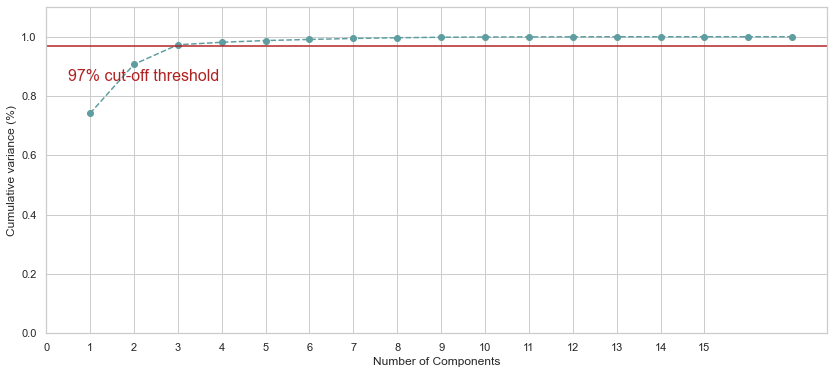

In [53]:
from sklearn.decomposition import PCA
pca_data = PCA()

principalComponents = pca_data.fit_transform(X_preprocessed_df)

plt.rcParams["figure.figsize"] = (14,6)

fig, ax = plt.subplots()
xi = np.arange(1, 18, step=1)
yi = np.cumsum(pca_data.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, yi, marker='o', linestyle='--', color='cadetblue')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 16, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')

plt.axhline(y=0.97, color='firebrick', linestyle='-')
plt.text(0.5, 0.85, '97% cut-off threshold', color = 'firebrick', fontsize=16)

plt.show()

> According to PCA, only 3 features explain 97% of the variability in the data. So, we will not use PCA. 

In [54]:
set_config(display="diagram")
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('temp_dropper', 'drop', ['temp']),
                                ('atemp_fill_values',
                                 Pipeline(steps=[('atemp_imputer',
                                                  KNNImputer(n_neighbors=2))]),
                                 ['atemp']),
                                ('hum_fill_values',
                                 Pipeline(steps=[('hum_imputer',
                                                  KNNImputer(n_neighbors=2))]),
                                 ['hum']),
                                ('wind_fill_values',
                                 SimpleImputer(strategy='median'),
                                 ['windspeed']),
                                ('weathersit_fill_values',
                                 Pipeline(steps=[('weathersit_fill',
                                                  FunctionTransformer(func=<function ffill_weather at 0x7fc9cdd56af0>)),
                                                 ('weathersit_encode',
                                                  OneHotEncoder())]),
                                 ['weathersit'])])

### DON'T RUN
**param_grid** helps us find the optimal model with the best hyperparameters. We have tried different hyperparameters to find the best one. 

In [55]:
#param_grid = [
 #   {
 #       "regression": [LinearRegression()],
 #       "regression__normalize": [False]
 #   },
 #   {
 #       "regression": [LogisticRegression()], 
  #      "regression__C": range(1,5),
  #      "regression__penalty": ['l2']  
  #  },
#    {
#        "regression": [DecisionTreeRegressor()], 
#        "regression__random_state": [100],
#        "regression__max_depth": [5, 7, 10]
    #    "regression__max_leaf_nodes": [1],
 #   },
 #   { 
 #       "regression": [SVC()], 
 #       "regression__kernel" : ['poly'],
 #       "regression__gamma": np.linspace(0.1,10,num=3)
 #   },
 #   {
 #       "regression": [RandomForestRegressor()],
 #       "regression__random_state": [100],
 #       "regression__max_depth": [5, 7, 10],
 #       "regression__n_estimators": [20, 30], 
 #       "regression__max_features": [0.7]
 #   },
 #       {
 #       "logisticregression": [KNeighborsClassifier()], 
 #       "logisticregression__n_neighbors": list(range(3,10)),
#    },
#    
#]

### RUN!

In [56]:
param_grid = [
    {
        "regression": [LinearRegression()],
        "regression__normalize": [False],
    },
    {
        "regression": [DecisionTreeRegressor()], 
        "regression__max_depth": [10], 
        "regression__random_state": [100],
    },
    {
        "regression": [RandomForestRegressor()],
        "regression__random_state": [100],
        "regression__max_depth": [10],
        "regression__n_estimators": [30], 
        "regression__max_features": [0.7]
    }
]

> Best three models and hyperparameters that will be used.

We created a simple pipepline with preprocessing and regression!

In [57]:
clf = Pipeline([
    ("preprocessing", preprocessing),
    ("regression", RandomForestRegressor())
 ])

In [58]:
clf = GridSearchCV(clf, param_grid, n_jobs=-1, cv=10, scoring="r2")

In [59]:
clf.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('temp_dropper',
                                                                         'drop',
                                                                         ['temp']),
                                                                        ('atemp_fill_values',
                                                                         Pipeline(steps=[('atemp_imputer',
                                                                                          KNNImputer(n_neighbors=2))]),
                                                                         ['atemp']),
                                                                        ('hum_fill_values',
                                                                         Pipeline(steps=[('hum_imputer',
                                                                                          KNNImputer(n_neighbors=2))]),
                                                                         ['hum']),
                                                                        ('wind_fill_value...
                          'regression__normalize': [False]},
                         {'regression': [DecisionTreeRegressor()],
                          'regression__max_depth': [10],
                          'regression__random_state': [100]},
                         {'regression': [RandomForestRegressor(max_depth=10,
                                                               max_features=0.7,
                                                               n_estimators=30,
                                                               random_state=100)],
                          'regression__max_depth': [10],
                          'regression__max_features': [0.7],
                          'regression__n_estimators': [30],
                          'regression__random_state': [100]}],
             scoring='r2')

In [60]:
clf.best_score_

0.775222765770075

> The best score achieved is 0.77!

In [61]:
clf.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('temp_dropper', 'drop',
                                                  ['temp']),
                                                 ('atemp_fill_values',
                                                  Pipeline(steps=[('atemp_imputer',
                                                                   KNNImputer(n_neighbors=2))]),
                                                  ['atemp']),
                                                 ('hum_fill_values',
                                                  Pipeline(steps=[('hum_imputer',
                                                                   KNNImputer(n_neighbors=2))]),
                                                  ['hum']),
                                                 ('wind_fill_values',
                                                  SimpleImputer(strategy='median'),
                                                  ['windspeed']),
                                                 ('weathersit_fill_values',
                                                  Pipeline(steps=[('weathersit_fill',
                                                                   FunctionTransformer(func=<function ffill_weather at 0x7fc9cdd56af0>)),
                                                                  ('weathersit_encode',
                                                                   OneHotEncoder())]),
                                                  ['weathersit'])])),
                ('regression',
                 RandomForestRegressor(max_depth=10, max_features=0.7,
                                       n_estimators=30, random_state=100))])

In [62]:
predictions = clf.predict(X_test)

In [63]:
predictions

array([163.95982049, 101.74479415,  81.83574556, ..., 165.76137279,
       141.11660926,  93.00012986])

In [64]:
comparison_df = y_test[['cnt']]

In [65]:
comparison_df['predictions'] = predictions
comparison_df

,cnt,predictions
instant,,
14492,168,163.959820
14493,79,101.744794
14494,69,81.835746
14495,35,34.763088
14496,12,10.498416
...,...,...
17375,119,333.553552
17376,89,238.912299
17377,90,165.761373


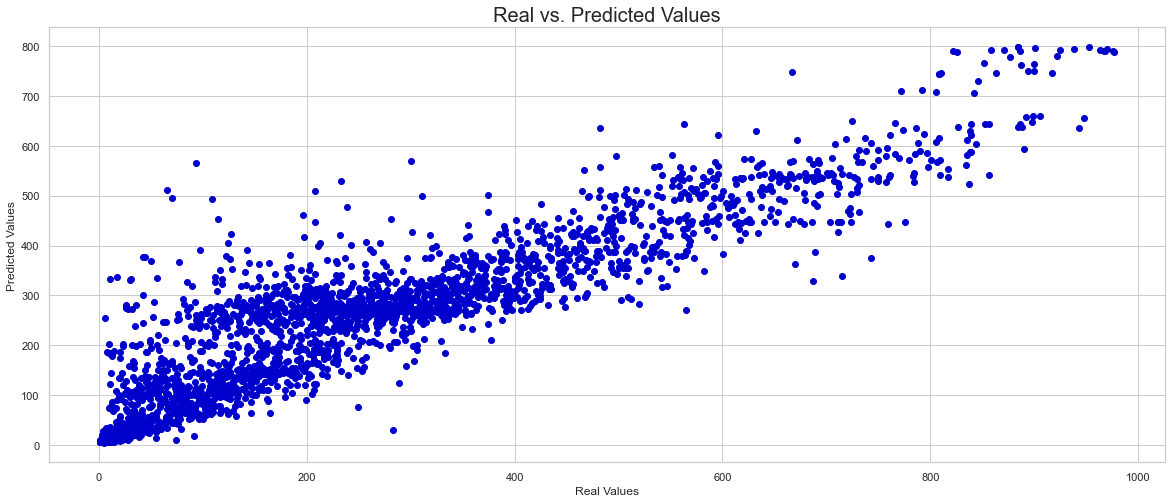

In [80]:
fig, ax = plt.subplots(figsize=(20,8))
ax.scatter(x=comparison_df["cnt"], y=comparison_df["predictions"], color = "mediumblue")
plt.xlabel("Real Values")
plt.ylabel ("Predicted Values")
plt.title("Real vs. Predicted Values", size = 20)
plt.show()

Let's visualize the difference between the predicted and actual bike rentals!

In [66]:
comparison_df["% difference"]=(comparison_df["cnt"]-comparison_df["predictions"])/(comparison_df["cnt"])

In [67]:
comparison_df.head()

,cnt,predictions,% difference
instant,,,
14492,168,163.959820,0.024049
14493,79,101.744794,-0.287909
14494,69,81.835746,-0.186025
14495,35,34.763088,0.006769
14496,12,10.498416,0.125132


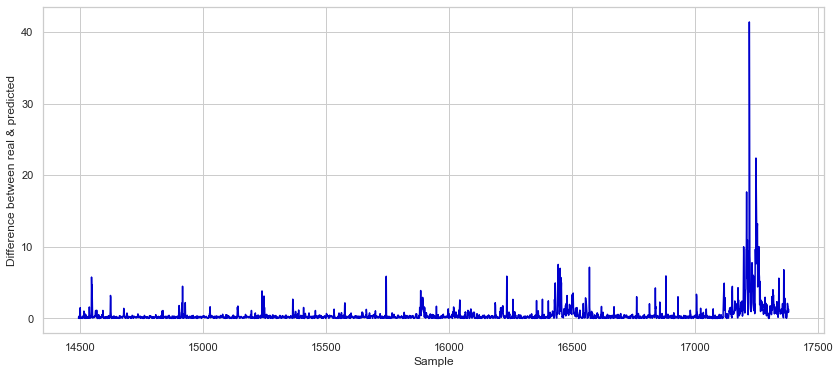

In [92]:
abs(comparison_df["% difference"]).plot(color = "mediumblue") # We plot the percentage difference
plt.xlabel("Sample")
plt.ylabel("Difference between real & predicted")
plt.show()

In [69]:
comparison_df["% difference"].mean()

-0.3581529813714243

> It is interesting how our predictions are, on average, 3.5% below the actual bike demand

In [70]:
# Add a new column with the corrected difference
comparison_df["corrected"]=comparison_df["predictions"]*1.03582
comparison_df.head() 

,cnt,predictions,% difference,corrected
instant,,,,
14492,168,163.959820,0.024049,169.832861
14493,79,101.744794,-0.287909,105.389293
14494,69,81.835746,-0.186025,84.767102
14495,35,34.763088,0.006769,36.008302
14496,12,10.498416,0.125132,10.874470


In [71]:
comparison_df["model prediction % error"]=(comparison_df["cnt"]-comparison_df["predictions"])
comparison_df["model prediction % error"].mean()

8.12461972447922

> The mean percentage error is 8.12% between the predicted and actual demand.

In [72]:
comparison_df["corrected prediction % error"]=comparison_df["corrected"]-(comparison_df["cnt"])
comparison_df["corrected prediction % error"].mean()

0.18947884158821426

In [73]:
comparison_df.head(20)

,cnt,predictions,% difference,corrected,model prediction % error,corrected prediction % error
instant,,,,,,
14492,168,163.959820,0.024049,169.832861,4.040180,1.832861
14493,79,101.744794,-0.287909,105.389293,-22.744794,26.389293
14494,69,81.835746,-0.186025,84.767102,-12.835746,15.767102
14495,35,34.763088,0.006769,36.008302,0.236912,1.008302
14496,12,10.498416,0.125132,10.874470,1.501584,-1.125530
14497,22,10.870896,0.505868,11.260291,11.129104,-10.739709
14498,36,34.676971,0.036751,35.919100,1.323029,-0.080900
14499,66,165.323332,-1.504899,171.245214,-99.323332,105.245214
14500,162,204.766895,-0.263993,212.101645,-42.766895,50.101645
